In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from itertools import combinations as comb

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_prefix = '/content/drive/MyDrive/final project/'

file = "churn.csv"

In [ ]:
churn = pd.read_csv(path_prefix+file)
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
drop = ['RowNumber','CustomerId','Surname']
churn.drop(drop, axis=1, inplace=True)

In [ ]:
churn_num = churn.select_dtypes('number').columns
churn_cat = churn.select_dtypes('object').columns

# Splitting data

In [ ]:
X = churn.drop('Exited', axis=1)
y = churn['Exited']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.2)

print(f'shape X_train: {X_train.shape}')
print(f'shape X_test: {X_test.shape}')
print(f'shape y_train: {y_train.shape}')
print(f'shape y_test: {y_test.shape}')

shape X_train: (8000, 10)
shape X_test: (2000, 10)
shape y_train: (8000,)
shape y_test: (2000,)


In [ ]:
def train_pre(X_train, X_test):
    X_train_enc = X_train.copy()
    X_num = X_train_enc.select_dtypes('number').columns
    X_cat = X_train_enc.select_dtypes('object').columns
    
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
    X_train_enc[X_cat] = oe.fit_transform(X_train_enc[X_cat])
    
    knn = KNNImputer(n_neighbors=5)
    X_train_imp = pd.DataFrame(knn.fit_transform(X_train_enc), columns=X_train_enc.columns)
    
    X_train_imp[X_cat] = oe.inverse_transform(X_train_imp[X_cat])
    
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_imp[X_cat]).toarray(),
                               columns=ohe.get_feature_names_out(X_cat))
    
    ss = StandardScaler()
    X_train_ss = pd.DataFrame(ss.fit_transform(X_train_imp[X_num]),
                              columns= X_num)
    
    X_train_trans = pd.concat([X_train_ss, X_train_ohe], axis=1)
    
    X_test_enc = X_test.copy()
    
    X_test_enc[X_cat] = oe.transform(X_test_enc[X_cat])
    X_test_imp = pd.DataFrame(knn.transform(X_test_enc), columns=X_train_enc.columns)
    X_test_imp[X_cat] = oe.inverse_transform(X_test_imp[X_cat])
    X_test_ohe = pd.DataFrame(ohe.transform(X_test_imp[X_cat]).toarray(),
                               columns=ohe.get_feature_names_out(X_cat))
    X_test_ss = pd.DataFrame(ss.transform(X_test_imp[X_num]),
                              columns= X_num)
    X_test_trans = pd.concat([X_test_ss, X_test_ohe], axis=1)
    
    return X_train_trans, X_test_trans

In [ ]:
X_train_trans = train_pre(X_train, X_test)[0]
X_test_trans = train_pre(X_train, X_test)[1]

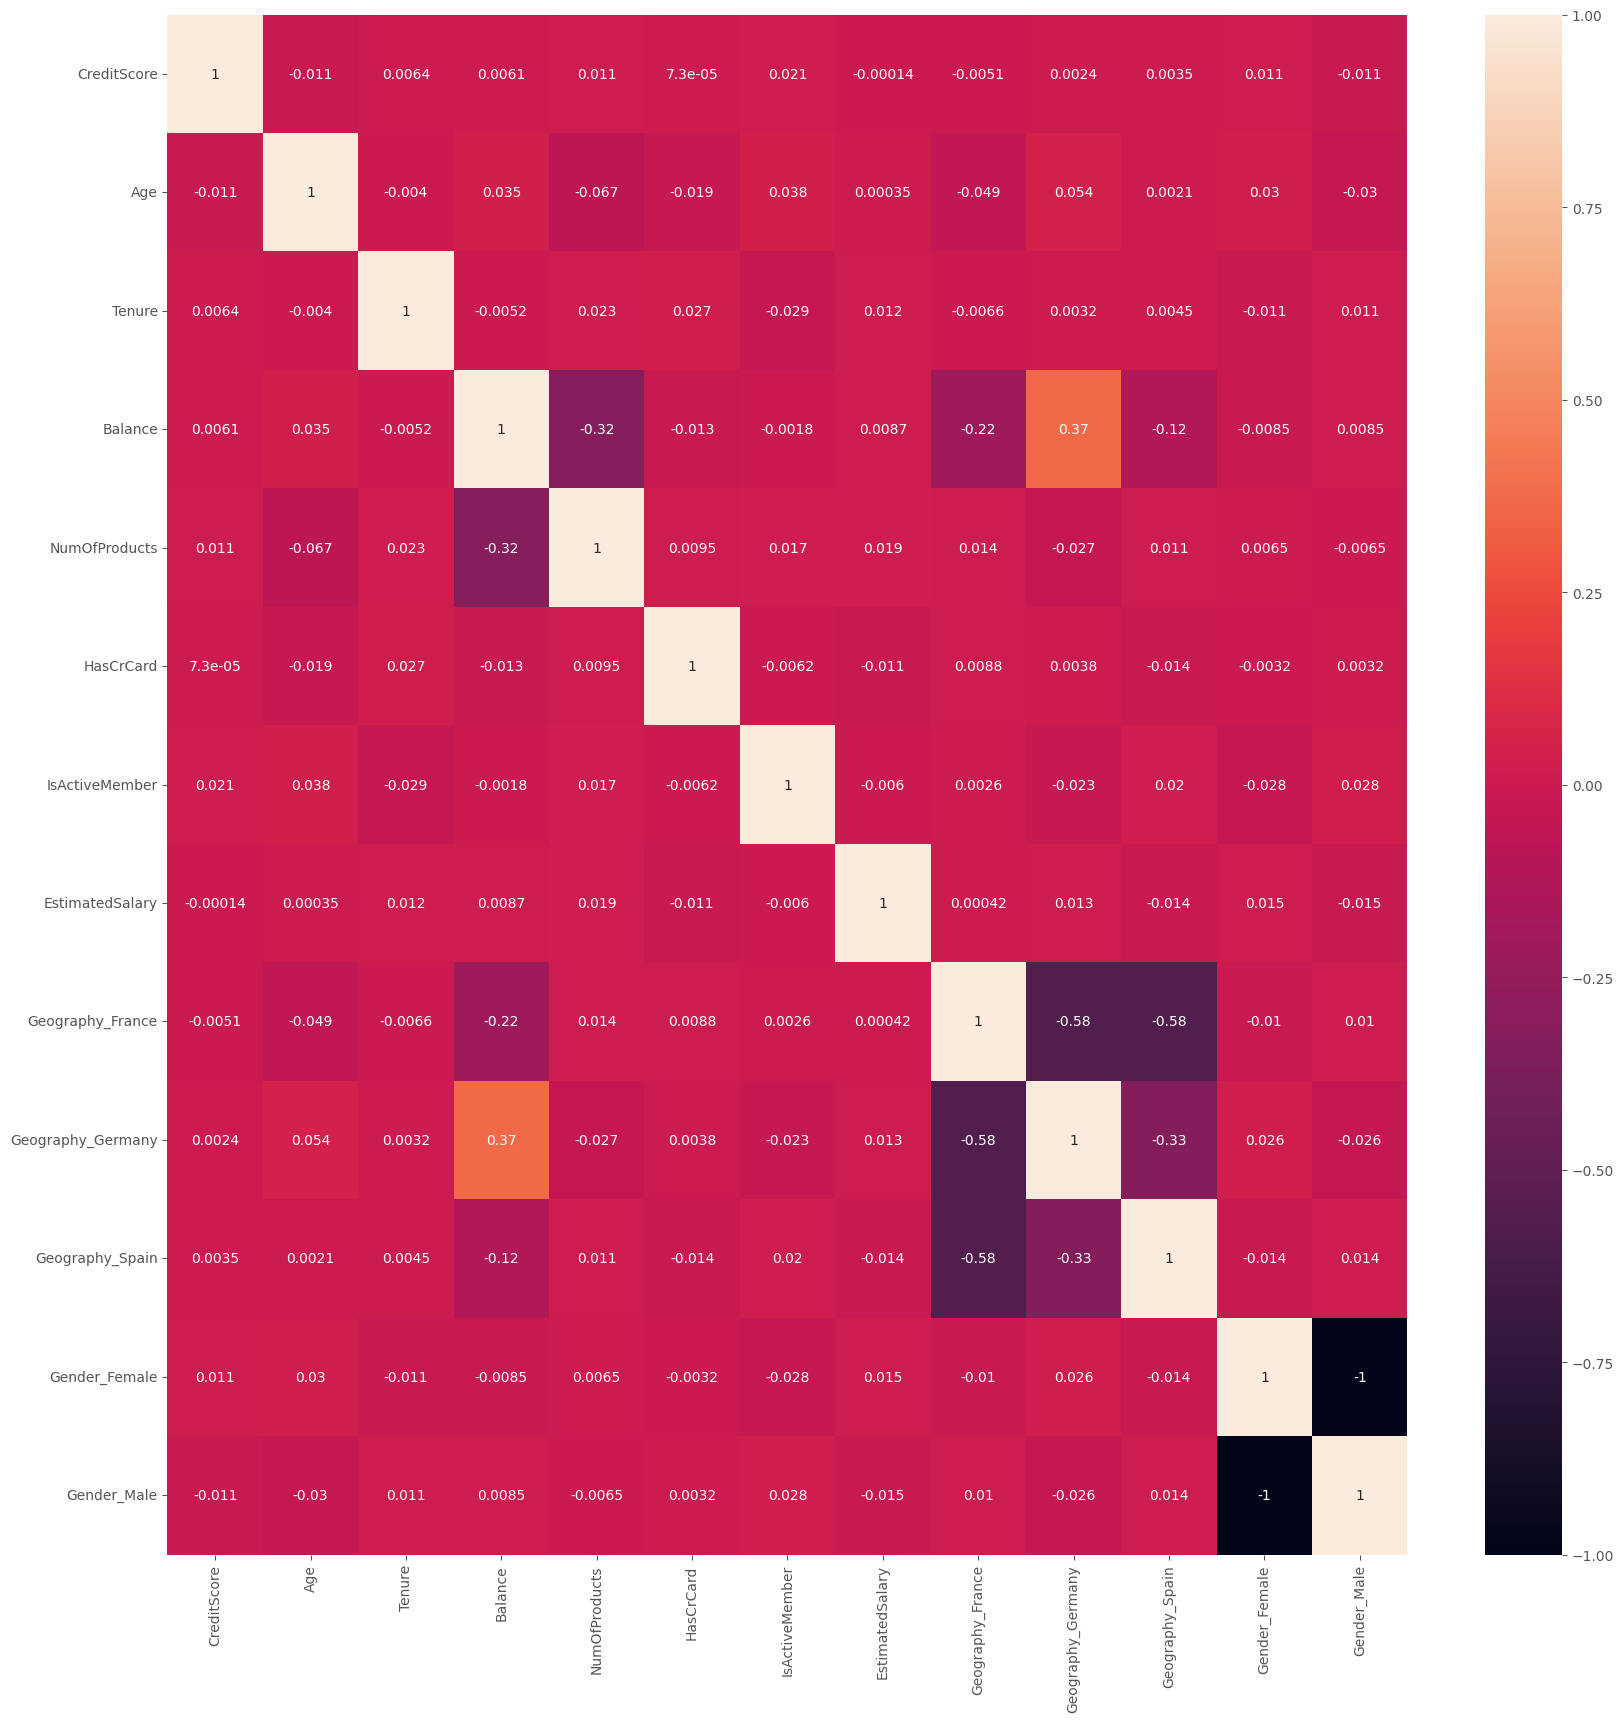

In [ ]:
plt.figure(figsize=(20,20))
corr = X_train_trans.corr(method='spearman')
sns.heatmap(corr,vmin=-1, vmax=1, annot=True)
plt.show()

# Undersampling: Neighborhood Cleaning Rule

In [ ]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

ncr = NeighbourhoodCleaningRule()

X_train_trans, y_train = ncr.fit_resample(X_train_trans, y_train)

X_test_trans, y_test = ncr.fit_resample(X_test_trans, y_test)

# Normal distribution

In [ ]:
def outlier(x):
    q1 = np.nanpercentile(x, 25)
    q3 = np.nanpercentile(x, 75)
    iqr = q3 - q1
    lower_fence = q1 - (1.5 * iqr)
    upper_fence = q3 + (1.5 * iqr)
    
    outlier = []
    for num in x:
        if num < lower_fence:
            outlier.append(num)
        if num > upper_fence:
            outlier.append(num)
            
    non_outlier = []
    for num in x:
        if num >= lower_fence:
            non_outlier.append(num)
        if num <= upper_fence:
            non_outlier.append(num)
    
 #   print(f'sum of unique value : {len(outlier)}' )
  #  print(f'lower_value: {np.min(non_outlier)}')
  #  print(f'upper_vaue: {np.max(non_outlier)}')

1. CreditScore


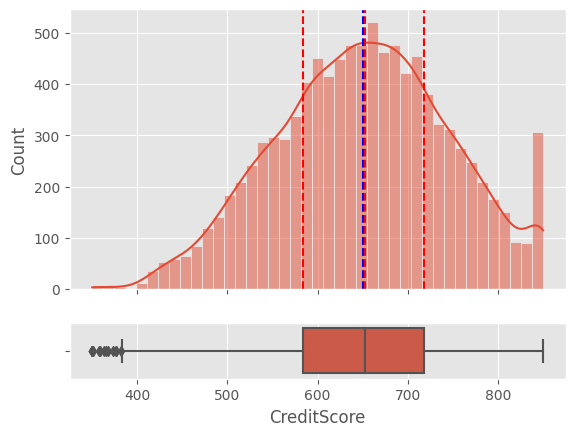

 
 
 
Data skewed with skew is -2.921350049463535
 
Data not normal
--------------------------------------------------
 
2. Age


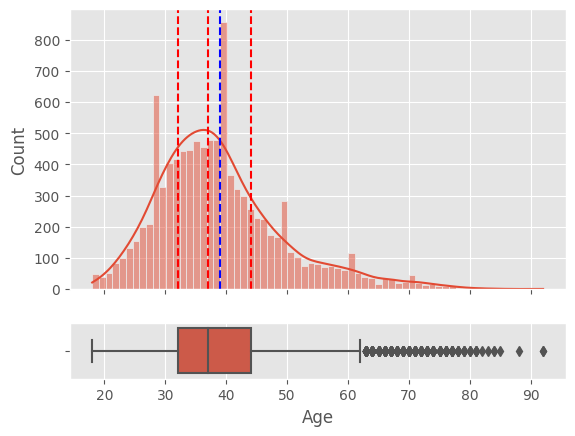

 
 
 
Data skewed with skew is 34.71381902710585
 
Data not normal
--------------------------------------------------
 
3. Tenure


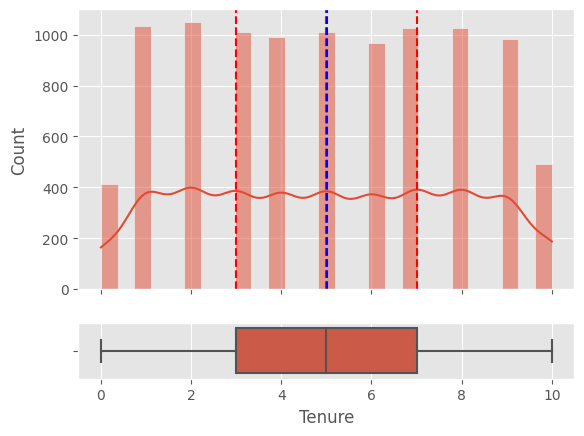

 
 
 
Data not skewed
 
Data not normal
--------------------------------------------------
 
4. Balance


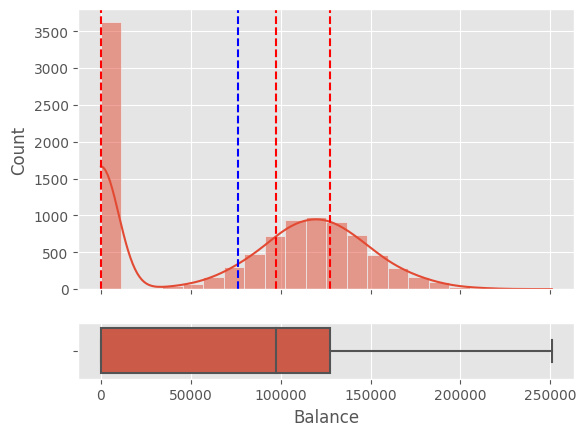

 
 
 
Data skewed with skew is -5.735943388118224
 
Data not normal
--------------------------------------------------
 
5. NumOfProducts


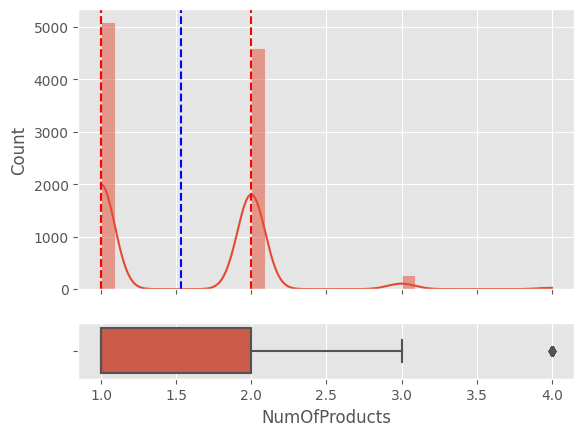

 
 
 
Data skewed with skew is 27.308956247437614
 
Data not normal
--------------------------------------------------
 
6. HasCrCard


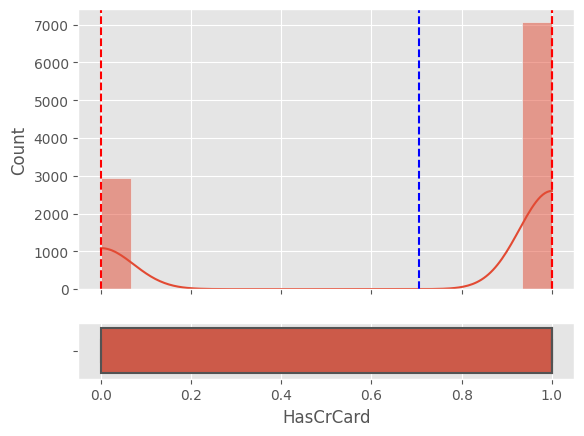

 
 
 
Data skewed with skew is -31.80680270602491
 
Data not normal
--------------------------------------------------
 
7. IsActiveMember


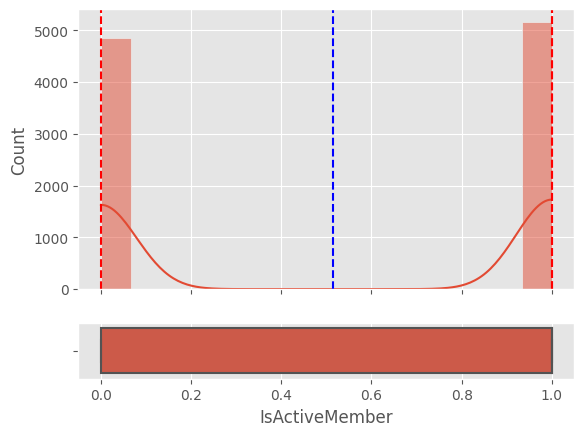

 
 
 
Data skewed with skew is -2.466548666286503
 
Data not normal
--------------------------------------------------
 
8. EstimatedSalary


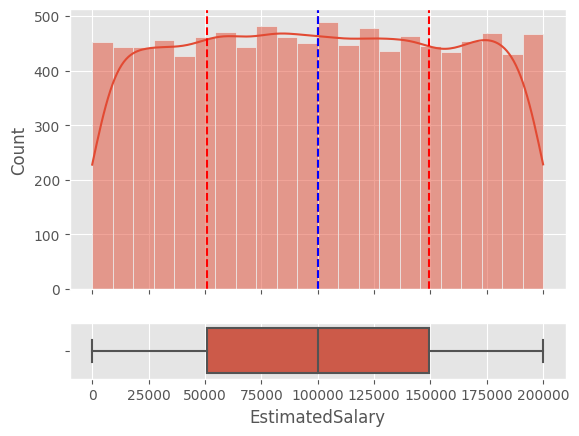

 
 
 
Data not skewed
 
Data not normal
--------------------------------------------------
 
9. Exited


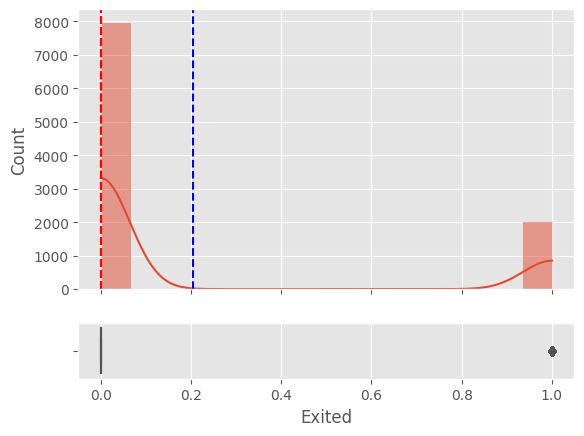

 
 
 
Data skewed with skew is 45.099913008252294
 
Data not normal
--------------------------------------------------
 


In [ ]:
norm_data = []
for y,x in enumerate(churn_num,1):
    print(f'{y}. {x}')
    fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[5,1]})
    sns.histplot(data=churn, x=x, kde=True, ax=ax[0])
    ax[0].axvline(np.nanpercentile(churn[x], 25), c='red',linestyle='--')
    ax[0].axvline(np.nanpercentile(churn[x], 50), c='red',linestyle='--')
    ax[0].axvline(np.nanpercentile(churn[x], 75), c='red',linestyle='--')
    ax[0].axvline(np.mean(churn[x]), c='blue',linestyle='--')
    
    sns.boxplot(data=churn, x=x, ax=ax[1])
    ax[1].set_xlabel(f'{x}')
    plt.show()
    print(' ')
    churn[x].describe()
    print(' ')
    outlier(churn[x])
    print(' ')
    sk, pval = st.skewtest(churn[x])
    if pval < 0.05:
        print(f'Data skewed with skew is {sk}')
    else:
        print(f'Data not skewed')
    print(' ')
    norm, pval = st.normaltest(churn[x])
    if pval < 0.05:
        print(f'Data not normal')
    else:
        print(f'Data normal')
        norm_data.append(x)
    print('-'*50)
    print(' ')

# Feature Selection

In [ ]:
drop = []

for col1, col2 in comb(X_train_trans.columns, 2):
    if (col1 in norm_data) & (col2 in norm_data):
        pear, pval1 = st.pearsonr(X_train_trans[col1],X_train_trans[col2])
        if (pear > 0.8) | (pear < -0.8):
            drop.append(col1)
    else:
        spear, pval2 = st.spearmanr(X_train_trans[col1],X_train_trans[col2])
        if (spear > 0.8) | (spear < -0.8):
            drop.append(col1)
        
drop

['Gender_Female']

In [ ]:
X_train_trans.drop(drop, axis=1, inplace=True)
X_test_trans.drop(drop, axis=1, inplace=True)

In [ ]:
mi_col = pd.DataFrame({'col': X_train_trans.columns,
                       'mi':mutual_info_classif(X_train_trans, y_train, random_state=42)}).sort_values('mi')
mi_col

,col,mi
0,CreditScore,0.000000
5,HasCrCard,0.000000
7,EstimatedSalary,0.000088
10,Geography_Spain,0.002585
8,Geography_France,0.010878
2,Tenure,0.010880
11,Gender_Male,0.015306
3,Balance,0.017366
6,IsActiveMember,0.019497
9,Geography_Germany,0.034002


In [ ]:
sel = mi_col[mi_col['mi'] !=0]
sel

,col,mi
7,EstimatedSalary,0.000088
10,Geography_Spain,0.002585
8,Geography_France,0.010878
2,Tenure,0.010880
11,Gender_Male,0.015306
3,Balance,0.017366
6,IsActiveMember,0.019497
9,Geography_Germany,0.034002
4,NumOfProducts,0.107582
1,Age,0.121847


In [ ]:
X_train_trans = X_train_trans[sel['col']]
X_train_trans

,EstimatedSalary,Geography_Spain,Geography_France,Tenure,Gender_Male,Balance,IsActiveMember,Geography_Germany,NumOfProducts,Age
0,1.042084,0.0,1.0,0.684723,1.0,-1.226059,-1.030206,0.0,-0.910256,1.715086
1,-0.623556,0.0,0.0,-0.696202,1.0,0.413288,-1.030206,1.0,-0.910256,-0.659935
2,-0.290199,0.0,1.0,-0.005739,1.0,-1.226059,-1.030206,0.0,0.808830,-0.184931
3,0.576966,0.0,1.0,1.375185,0.0,-1.226059,0.970680,0.0,0.808830,-0.089930
4,1.452783,0.0,1.0,1.375185,1.0,-1.226059,-1.030206,0.0,-0.910256,-0.469934
...,...,...,...,...,...,...,...,...,...,...
6029,1.113821,0.0,0.0,-1.731895,0.0,1.668140,-1.030206,1.0,0.808830,-0.374933
6030,-1.294966,1.0,0.0,0.339492,0.0,-1.226059,-1.030206,0.0,-0.910256,-0.374933
6031,0.901685,1.0,0.0,-0.005739,1.0,-1.226059,-1.030206,0.0,0.808830,3.330101
6032,-0.558088,0.0,1.0,1.375185,0.0,-0.073747,0.970680,0.0,0.808830,-0.184931


In [ ]:
X_test_trans = X_test_trans[sel['col']]
X_test_trans

,EstimatedSalary,Geography_Spain,Geography_France,Tenure,Gender_Male,Balance,IsActiveMember,Geography_Germany,NumOfProducts,Age
0,-0.095021,0.0,1.0,0.684723,1.0,-1.226059,-1.030206,0.0,0.808830,-0.279932
1,0.099469,1.0,0.0,-0.350971,0.0,-1.226059,0.970680,0.0,0.808830,0.100072
2,-1.147374,1.0,0.0,-0.005739,1.0,1.011458,-1.030206,0.0,0.808830,-0.469934
3,1.452222,1.0,0.0,-1.731895,1.0,-1.226059,-1.030206,0.0,-0.910256,-0.469934
4,-0.730278,0.0,0.0,1.375185,1.0,0.871629,0.970680,1.0,0.808830,-0.849937
...,...,...,...,...,...,...,...,...,...,...
1453,-1.260425,0.0,1.0,-1.041433,1.0,1.254363,0.970680,0.0,-0.910256,-0.279932
1454,1.173903,0.0,0.0,-0.696202,1.0,0.562642,0.970680,1.0,0.808830,-0.184931
1455,0.870086,0.0,0.0,1.375185,0.0,0.833372,-1.030206,1.0,-0.910256,0.765078
1456,-1.479356,0.0,1.0,0.684723,1.0,-1.226059,-1.030206,0.0,0.808830,0.005071


# Parameter

In [ ]:
logreg_def = LogisticRegression(random_state=42)
tree_def = DecisionTreeClassifier(random_state=42)
rf_def = RandomForestClassifier(random_state=42)
xgb_def = XGBClassifier(random_state=42)

In [ ]:
model = [logreg_def,tree_def,rf_def,xgb_def]
model_list = ['logreg_def', 'tree_def','rf_def','xgb_def']

Logistic Regression

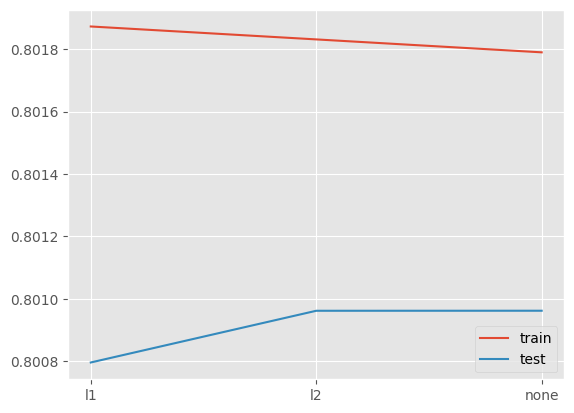

'none'

In [ ]:
x = ['l1','l2','none']
train = []
test = []

for val in x:
    logreg2 = LogisticRegression(random_state=42,
                                 solver='saga',
                                 penalty=val)
    cv = cross_validate(logreg2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

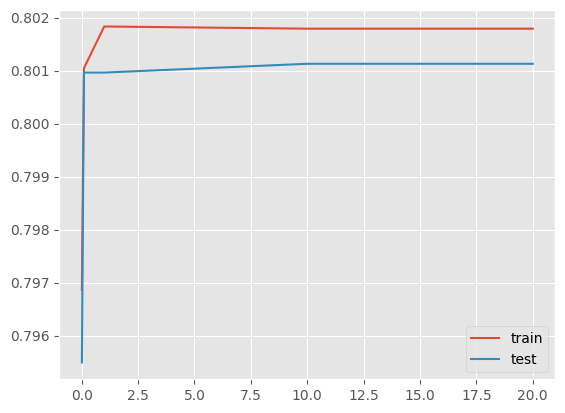

10

In [ ]:
x = [0.01, 0.1, 1, 10, 20]
train = []
test = []

for val in x:
    logreg2 = LogisticRegression(random_state=42,
                                 solver='saga',
                                 penalty='l2',
                                 C=val)
    cv = cross_validate(logreg2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
logreg_tun = LogisticRegression(random_state=42,
                                 solver='saga',
                                 penalty='l2',
                                 C=10)
model.append(logreg_tun)
model_list.append('logreg_tun')

Decision Tree

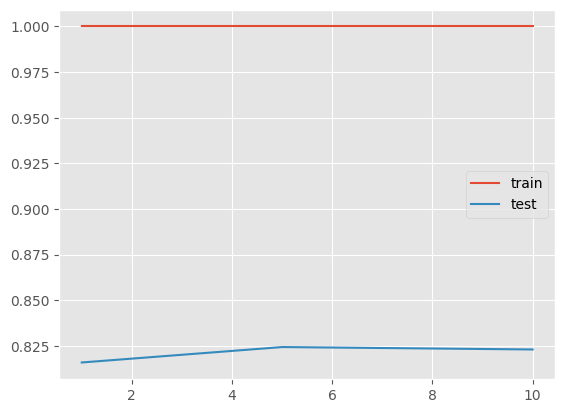

5

In [ ]:
x = [1,5,10]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                   max_features=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

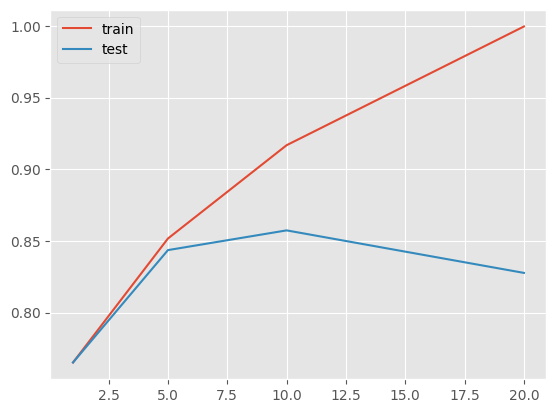

10

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                   max_features=4,
                                   max_depth=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

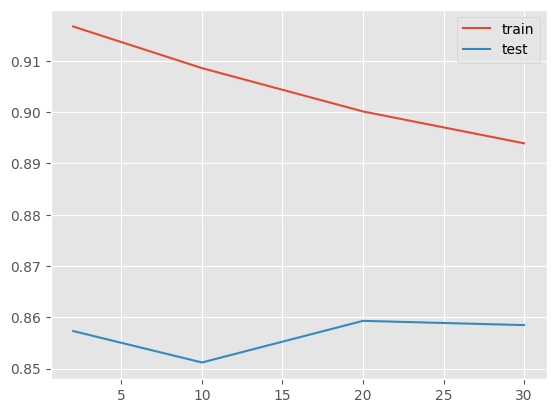

20

In [ ]:
x = [2,10,20,30]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                   max_features=4,
                                   max_depth=10,
                                   min_samples_split=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

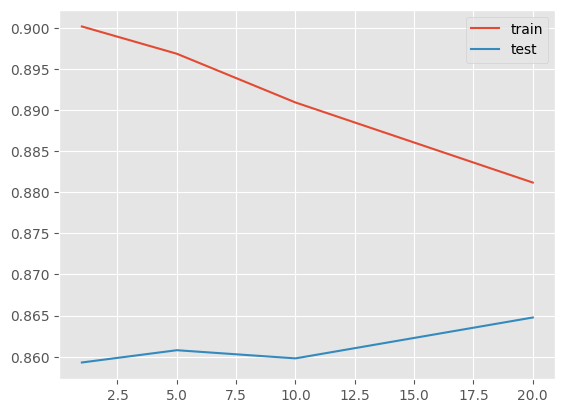

20

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                   max_features=4,
                                   max_depth=10,
                                   min_samples_split=20,
                                   min_samples_leaf=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

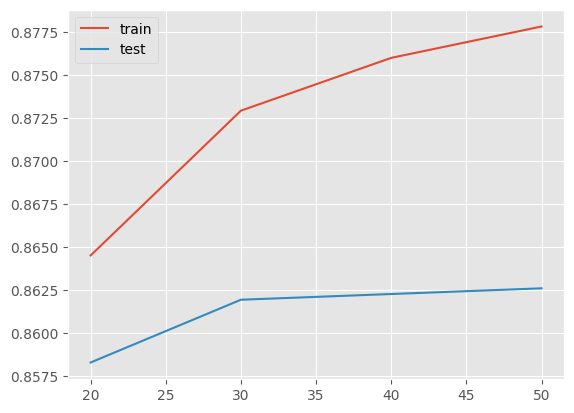

50

In [ ]:
x = [20,30,40,50]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                   max_features=4,
                                   max_depth=10,
                                   min_samples_split=20,
                                   min_samples_leaf=20,
                                   max_leaf_nodes=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
tree_tun = DecisionTreeClassifier(random_state=42,
                                   max_features=4,
                                   max_depth=10,
                                   min_samples_split=20,
                                   min_samples_leaf=20,
                                   max_leaf_nodes=50)

model.append(tree_tun)
model_list.append('tree_tun')

Random Forest

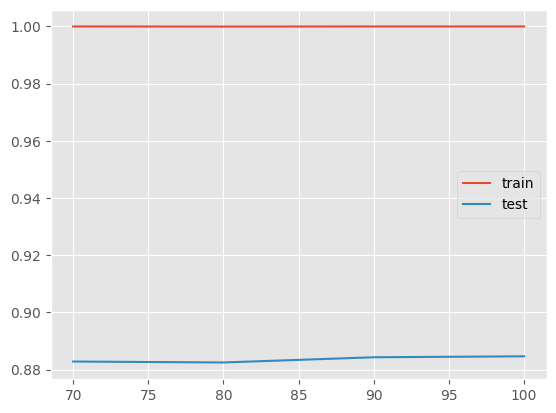

100

In [ ]:
x = [70,80,90,100]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

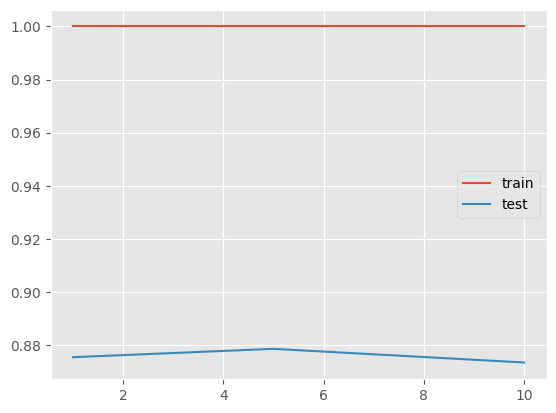

5

In [ ]:
x = [1,5,10]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=100,
                                 max_features=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

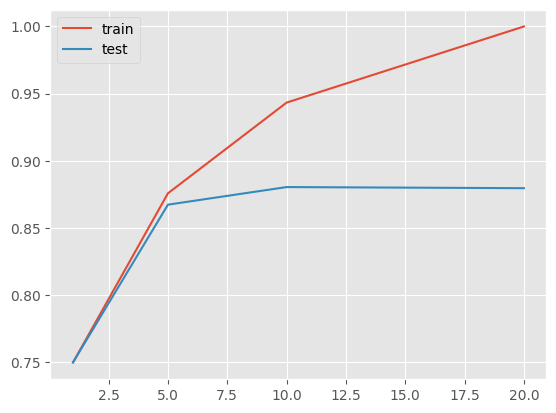

10

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=100,
                                 max_features=5,
                                 max_depth=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

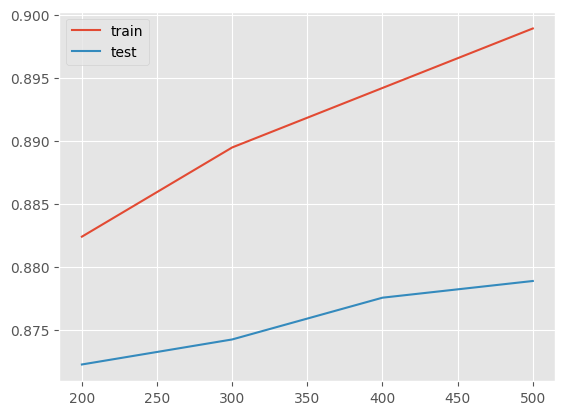

500

In [ ]:
x = [200,300,400,500]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=100,
                                 max_features=5,
                                 max_depth=10,
                                 max_samples=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

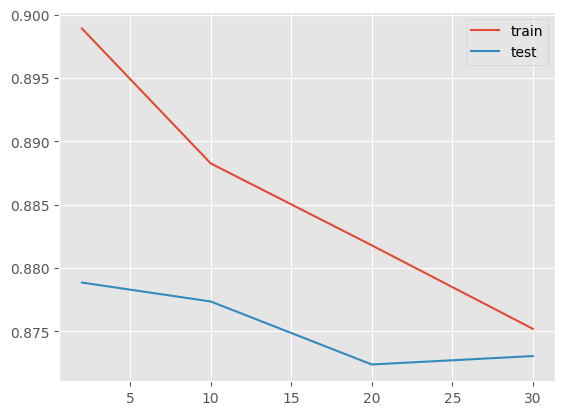

2

In [ ]:
x = [2,10,20,30]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=100,
                                 max_features=5,
                                 max_depth=10,
                                 max_samples=500,
                                 min_samples_split=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
rf_tun = RandomForestClassifier(random_state=42,
                                 n_estimators=100,
                                 max_features=5,
                                 max_depth=10,
                                 max_samples=500,
                                 min_samples_split=2)

model.append(rf_tun)
model_list.append('rf_tun')

xgboost

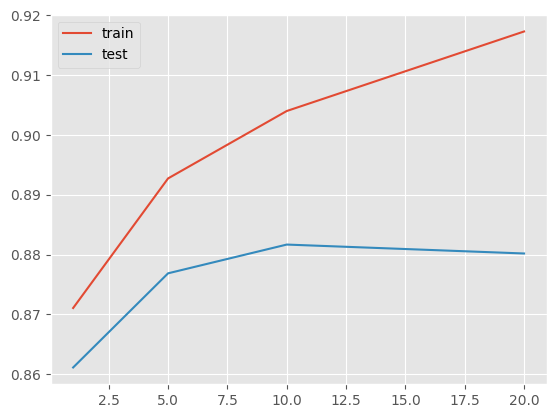

10

In [ ]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                        n_estimators=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

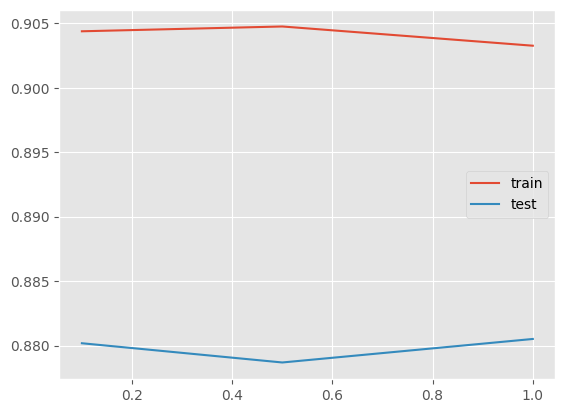

1

In [ ]:
x = [0.1,0.5,1]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                         n_estimators=10,
                         gamma=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

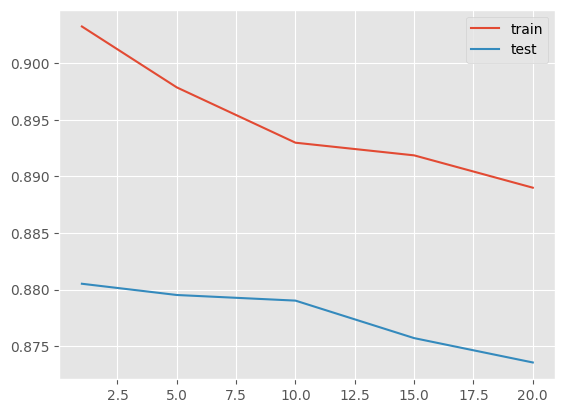

1

In [ ]:
x = [1,5,10,15,20]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                         n_estimators=10,
                         gamma=1,
                         reg_lambda=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

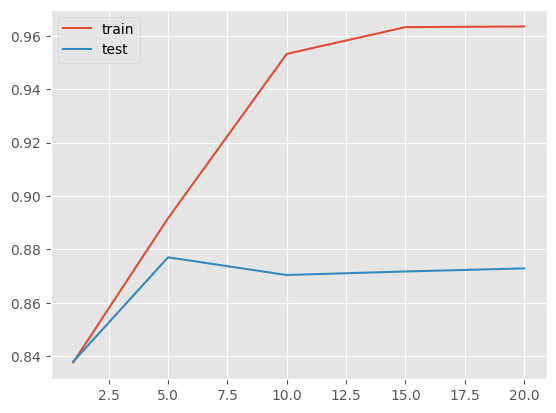

5

In [ ]:
x = [1,5,10,15,20]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                         n_estimators=10,
                         gamma=1,
                         reg_lambda=1,
                         max_depth=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [ ]:
xgb_tun = XGBClassifier(random_state=42,
                         n_estimators=10,
                         gamma=1,
                         reg_lambda=1,
                        max_depth=5)

model.append(xgb_tun)
model_list.append('xgb_tun')

# Result

In [ ]:
score = {'model': [],
         'acc': [],
         'roc': [],
         'recall': [],
         'f1_score': [],
         'npv': []}

for mod, mods in zip(model, model_list):
    for y in ['_test','_train']:
        if y == '_test':
            mod.fit(X_train_trans, y_train)
            tn1, fp1, fn1, tp1 = confusion_matrix(y_test, mod.predict(X_test_trans)).ravel()
            score['model'].append(mods+y)
            score['acc'].append(mod.score(X_test_trans, y_test))
            score['roc'].append(roc_auc_score(y_test, mod.predict_proba(X_test_trans)[:,1]))
            score['recall'].append(recall_score(y_test, mod.predict(X_test_trans)))
            score['f1_score'].append(f1_score(y_test, mod.predict(X_test_trans)))
            score['npv'].append(tn1/(tn1+fn1))
        elif y =='_train':
            mod.fit(X_train_trans, y_train)
            tn, fp, fn, tp = confusion_matrix(y_train, mod.predict(X_train_trans)).ravel()
            score['model'].append(mods+y)
            score['acc'].append(mod.score(X_train_trans, y_train))
            score['roc'].append(roc_auc_score(y_train, mod.predict_proba(X_train_trans)[:,1]))
            score['recall'].append(recall_score(y_train, mod.predict(X_train_trans)))
            score['f1_score'].append(f1_score(y_train, mod.predict(X_train_trans)))
            score['npv'].append(tn/(tn+fn))

pd.DataFrame(score).sort_values(['roc', 'acc', 'recall', 'f1_score','npv'], ascending=False)

,model,acc,roc,recall,f1_score,npv
3,tree_def_train,1.000000,1.000000,1.000000,1.000000,1.000000
5,rf_def_train,1.000000,1.000000,1.000000,1.000000,1.000000
7,xgb_def_train,0.972655,0.995687,0.913497,0.947502,0.968812
13,rf_tun_train,0.896586,0.948027,0.696933,0.784530,0.896393
15,xgb_tun_train,0.890951,0.934710,0.684663,0.772318,0.892333
11,tree_tun_train,0.879350,0.917096,0.686503,0.754552,0.891230
12,rf_tun_test,0.870370,0.910301,0.660934,0.740028,0.878735
14,xgb_tun_test,0.868313,0.910038,0.663391,0.737705,0.879082
4,rf_def_test,0.861454,0.898825,0.675676,0.731383,0.881402
6,xgb_def_test,0.858711,0.892441,0.685504,0.730366,0.883742


Feature Importance

In [ ]:
fi = pd.DataFrame(xgb_tun.feature_importances_,
                  index=xgb_tun.feature_names_in_,
                  columns=['importance']).sort_values(['importance'], ascending=False)
fi

,importance
Age,0.235223
IsActiveMember,0.231562
NumOfProducts,0.218090
Geography_Germany,0.097008
Gender_Male,0.052576
Balance,0.050417
Geography_France,0.049674
Geography_Spain,0.030972
EstimatedSalary,0.020679
Tenure,0.013798


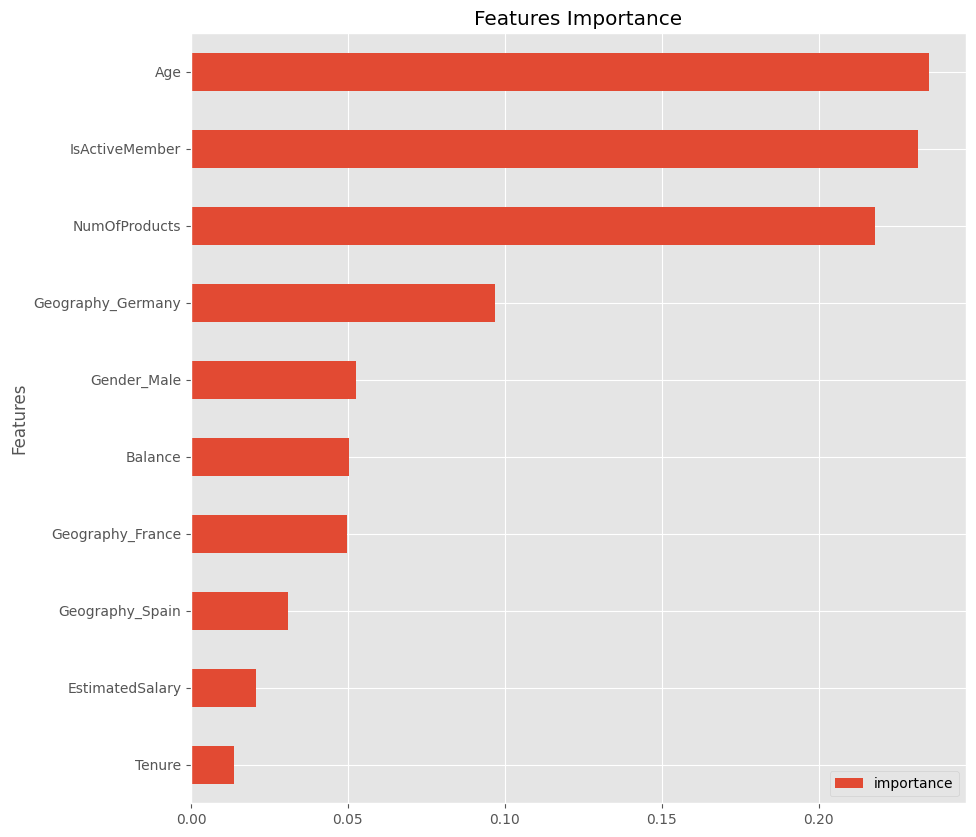

In [ ]:
ax = fi.sort_values('importance').plot(kind='barh', title='Features Importance', figsize=(10,10))
ax.set_ylabel('Features')
plt.show()
